In [18]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.linalg import cho_factor, cho_solve, LinAlgError
from scipy.fft import fft, fftfreq
from scipy.stats import shapiro, skew, kurtosis, ttest_rel, normaltest,jarque_bera
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import json
import math

import requests 
from scipy.optimize import minimize, Bounds, LinearConstraint
from typing import Union, Sequence, Tuple

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [19]:
url = "https://giris.epias.com.tr"
 
headertgt = {"Content-Type" : "application/x-www-form-urlencoded",
             "Accept" : "text/plain"}
 
paramtgt = {"username" : "ademyildirimmakine@gmail.com",
            "password" : "Ay.12345"}

In [20]:
date1 = "2025-01-01T00:00:00+03:00"
date2 = "2025-12-10T00:00:00+03:00"    #sontarihin tamamını alıyor

base_path    = "https://seffaflik.epias.com.tr/electricity-service"
TGT_response = requests.post(url+"/cas/v1/tickets", headers = headertgt, data = paramtgt)

header={"Content-Type" : "application/json",
        "Accept" : "application/json",
        "Accept-Language" :"en",
        "TGT" : TGT_response.text}
params = json.dumps({"startDate": date1, "endDate": date2,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
result  = requests.request("POST", base_path+"/v1/markets/dam/data/mcp",  data = params, headers=header)

In [21]:
df = pd.DataFrame(result.json()['items'])
dfhourly   = df[["price","priceUsd","priceEur"]]

df["USD"] = df["price"]/df["priceUsd"]*df["priceUsd"].mean()
df["EUR"] = df["price"]/df["priceEur"]*df["priceEur"].mean()
df['TRY'] = df["price"] 

df["Tarih"]  = df["date"].str[:10]
dfpivot = df.pivot_table(["USD","EUR","TRY"],"Tarih",aggfunc="mean")
dfdata  = df.pivot_table(["USD","EUR","TRY"],"Tarih",aggfunc="mean")

#dfdata["TRY"] = dfdata["TRY"] * (dfdata.mean()[0]/dfdata.mean()[1])
#dfdata["USD"] = dfdata["USD"] * (dfdata.mean()[0]/dfdata.mean()[2])
dfpivot.describe()

,EUR,TRY,USD
count,344.000000,344.000000,344.000000
mean,2608.948078,2599.165791,2598.062822
std,253.138134,452.960567,149.093798
min,2129.782990,779.938750,2333.123493
25%,2411.896454,2371.540521,2506.965298
50%,2681.223816,2644.215208,2614.228477
75%,2842.674317,2976.971042,2729.658117
max,2915.738728,3393.750417,2817.591955


10 aylık veri çekildi. Saatlik elektrik fiyatı elde edildikten sonra USD, TRY ve EUR biriminde datalar türetildi. Sonrasında günlük ortalama veriler kullanıldı. Veri aralığı içinde

- USD/MWh olan değerler, serinin maksimumuna bölündü. Bu sayede 0-1 arasında veri elde edildi.
- EUR/MWh olan değerler, EUR/USD ile çarpılarak artırıldı.
- TRY/MWh olan değerler, TRY/USD ile çarpılarak artırıldı.

Veriyi küçültüldü ve oranlarla aralarındaki büyüklük korundu. 

In [22]:
dfdata.boxplot()

<Axes: >

In [23]:
dfpivot["USD"] = dfpivot["USD"]/df['USD'][0]
dfpivot["EUR"] = dfpivot["EUR"]/df['USD'][0]
dfpivot["TRY"] = dfpivot["TRY"]/df['USD'][0]
dfpivot.plot()

<Axes: xlabel='Tarih'>

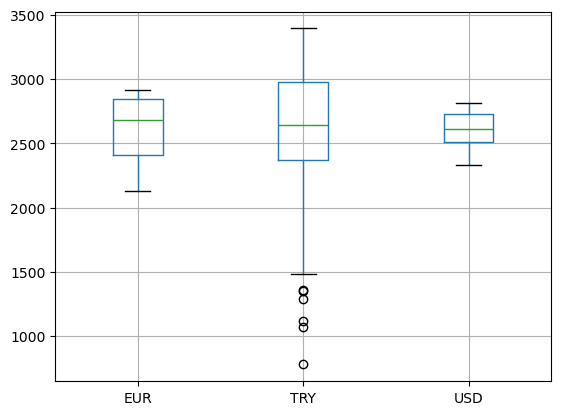

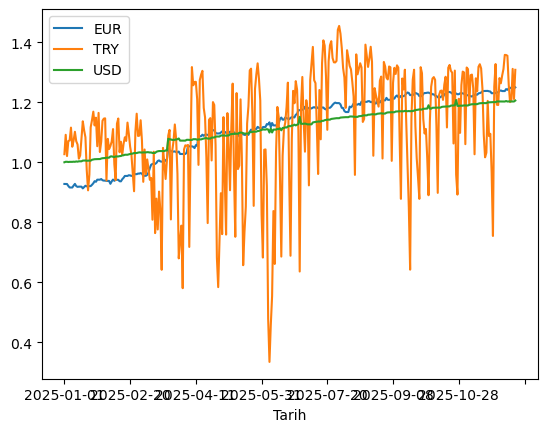

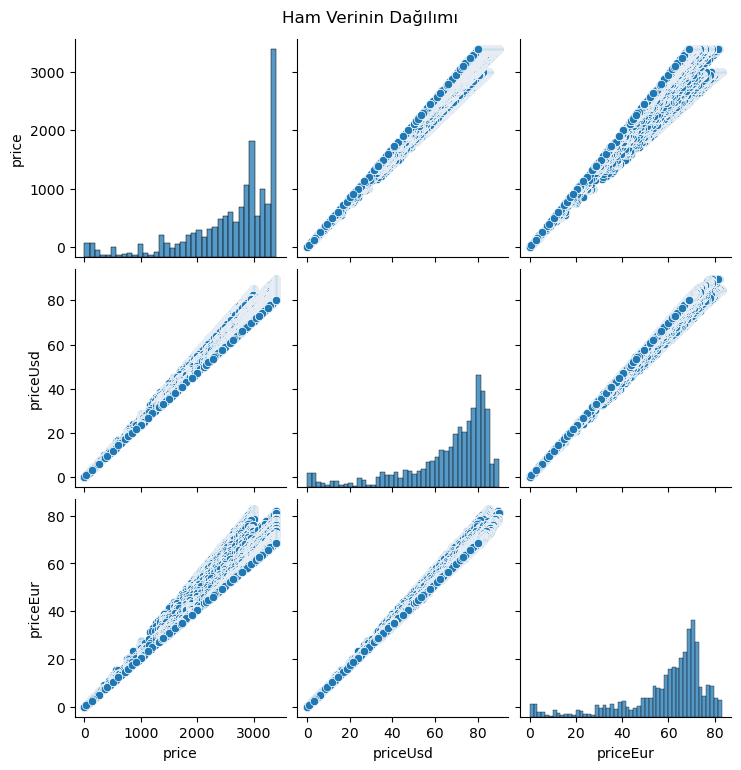

In [24]:
sns.pairplot(df[["price","priceUsd","priceEur"]].dropna())
plt.suptitle("Ham Verinin Dağılımı", y=1.02)
plt.show()

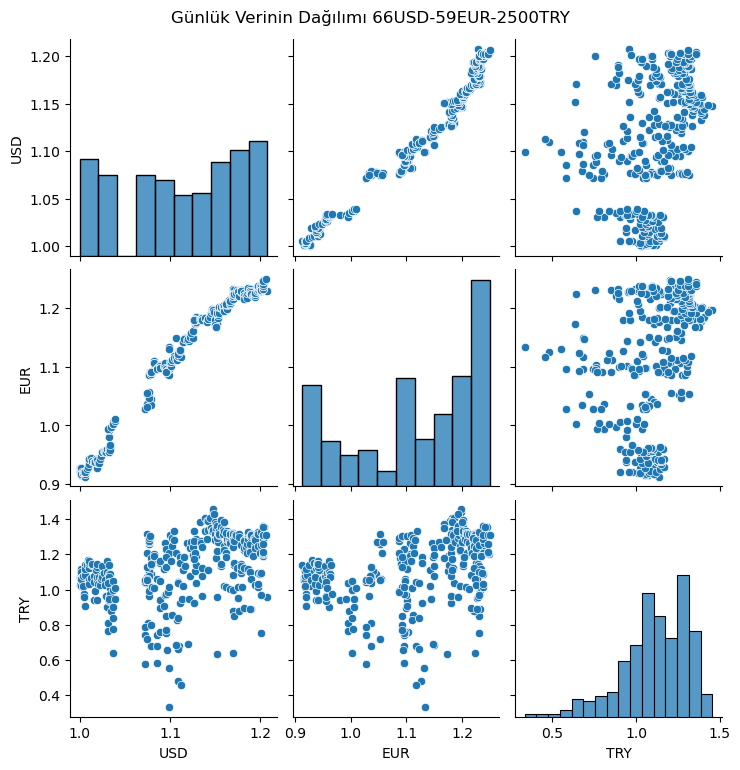

In [25]:
sns.pairplot(dfpivot[["USD","EUR","TRY"]].dropna())
plt.suptitle("Günlük Verinin Dağılımı 66USD-59EUR-2500TRY", y=1.02)
plt.show()

Yukarıdaki istatistiksel testlerde de görüleceği üzere veri normal dağılıma sahip değildir. 
Bu durumun tam belirlenmesi adına aşağıdaki testler uygulanmıştır. 
 - Q-Q diyagramının çıkarılması
 - P testi
 - Skewness testi
 - Kurtosis testi

Sonuçlar analiz edildiğinde verinin normal olmadığı ispatlanmış oldu. 

In [26]:
dfdata.mean()

EUR    2608.948078
TRY    2599.165791
USD    2598.062822
dtype: float64

In [27]:
t_stat, p_valueusdtry = ttest_rel(dfdata[["USD"]].dropna().values, dfdata[["TRY"]].dropna().values)
t_stat, p_valueusdeur = ttest_rel(dfdata[["USD"]].dropna().values, dfdata[["EUR"]].dropna().values)
t_stat, p_valueeurtry = ttest_rel(dfdata[["EUR"]].dropna().values, dfdata[["TRY"]].dropna().values)
print("p değeri usd-try:", p_valueusdtry)  # p < 0.05 ise anlaşmlı bir şekilde farklı
print("p değeri usd-eur:", p_valueusdeur)  # p < 0.05 ise anlaşmlı bir şekilde farklı
print("p değeri eur-try:", p_valueeurtry)  # p < 0.05 ise anlaşmlı bir şekilde farklı

p değeri usd-try: [0.96107994]
p değeri usd-eur: [0.06667726]
p değeri eur-try: [0.67278336]


In [28]:
def stat(data):
    name = data.name
    data = data.dropna().values
    stat, p = shapiro(data) 
    stat, pk2 = normaltest(data)
    stat, pjb = jarque_bera(data)
    
    print("Values", name)
    print("Shapiro  p-value:", f"{p:.3f}")              # p < 0.05 → veri normal dağılmıyor
    print("Kkare    p-value:", f"{pk2:.3f}")            # p < 0.05 → veri normal dağılmıyor
    print("jarque   p-value:", f"{pjb:.3f}")            # p < 0.05 → veri normal dağılmıyor ve dağılım simetrik mi?
    
    print("Skewness value  :", f"{skew(data):.3f}")      # çarpıklık 0'a yakın normal
    print("Kurtosis value  :", f"{kurtosis(data):.3f}")  # basıklık 0'a yakın normal
    print("Best Dist. lue  :", "veri dağılıma sahip değil") 
    
    # --- Q-Q Plot ---
    
    st.probplot(data, dist="norm", plot=plt)
    plt.title("Q-Q Plot")
    plt.show()  

Values USD
Shapiro  p-value: 0.000
Kkare    p-value: 0.000
jarque   p-value: 0.000
Skewness value  : -0.304
Kurtosis value  : -1.179
Best Dist. lue  : veri dağılıma sahip değil


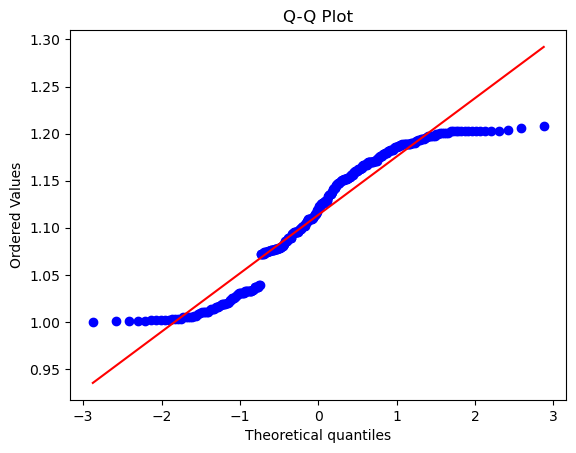

Values EUR
Shapiro  p-value: 0.000
Kkare    p-value: 0.000
jarque   p-value: 0.000
Skewness value  : -0.600
Kurtosis value  : -1.066
Best Dist. lue  : veri dağılıma sahip değil


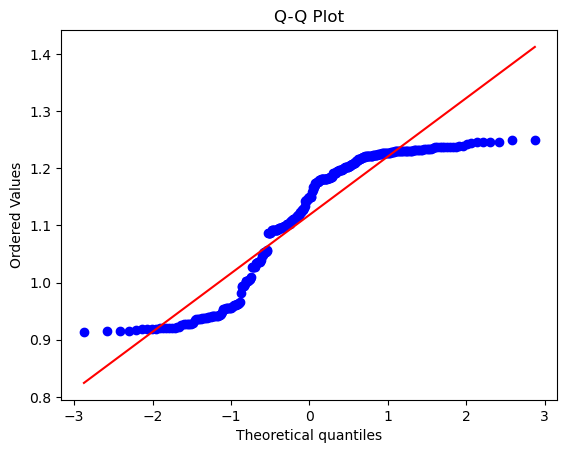

Values TRY
Shapiro  p-value: 0.000
Kkare    p-value: 0.000
jarque   p-value: 0.000
Skewness value  : -0.941
Kurtosis value  : 0.917
Best Dist. lue  : veri dağılıma sahip değil


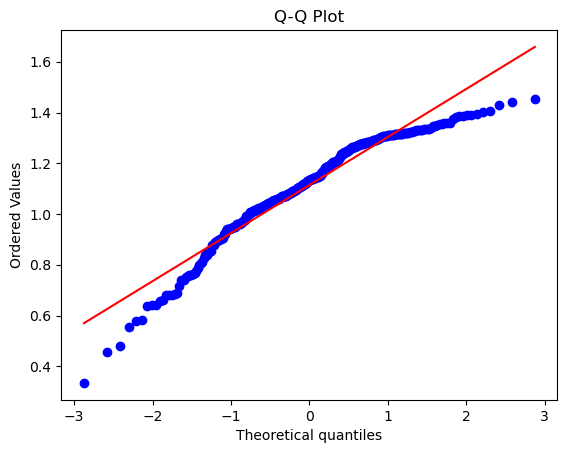

In [29]:
stat(dfpivot["USD"])
stat(dfpivot["EUR"])
stat(dfpivot["TRY"])

Enerji risk yönetimi için:
- Bu tür dağılımlarda CVaR mutlaka kullanılmalıdır
- Mean-variance modeli tail riskini tamamen gözden kaçırır
- Varyans düşük gözükür ama gerçek risk devasa çıkar
DesTRY → “tail-risk bombası”.
Bu grafik, enerji portföyünde des kaynaklarının ağırlığını direkt düşürmen gerektiğini işaret eder (özellikle risk toleransı yüksek değilse).

In [30]:
def analyze_time_series(series: pd.Series, alpha: float = 0.05, lags: int = 40):
    """
    Verilen zaman serisi için temel zaman serisi analizlerini yapar:
    1) ADF testi (durağanlık testi - unit root)
    2) KPSS testi (trend-stationarity testi)
    3) ACF ve PACF grafikleri

    Parametreler
    -----------
    series : pd.Series
        DatetimeIndex'e sahip zaman serisi (örneğin saatlik/günlük fiyat, talep vb.)
    alpha : float
        Testler için anlamlılık seviyesi (default 0.05)
    lags : int
        ACF/PACF için maksimum gecikme sayısı
    """

    # --- 0. Temizlik ---
    # NaN değerleri düş
    series_clean = series.dropna()

    print("=== Zaman Serisi Özet Bilgileri ===")
    print(f"Gözlem sayısı: {len(series_clean)}")
    print(f"Başlangıç tarihi: {series_clean.index.min()}")
    print(f"Bitiş tarihi    : {series_clean.index.max()}")
    print(f"Ortalama: {series_clean.mean():.4f}")
    print(f"Std sapma: {series_clean.std():.4f}")
    print()

    # =============================
    # 1) ADF Testi (Augmented Dickey-Fuller)
    # =============================
    print("=== 1) ADF Testi (Augmented Dickey-Fuller) ===")
    adf_result = adfuller(series_clean, autolag="AIC")
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]
    adf_usedlag = adf_result[2]
    adf_nobs = adf_result[3]
    adf_crit = adf_result[4]

    print(f"ADF İstatistiği: {adf_stat:.4f}")
    print(f"p-değeri       : {adf_pvalue:.4f}")
    print(f"Kullanılan lag : {adf_usedlag}")
    print(f"Efektif gözlem : {adf_nobs}")
    print("Kritik değerler:")
    for key, value in adf_crit.items():
        print(f"  {key}: {value:.4f}")

    if adf_pvalue < alpha:
        print(f"❗ Sonuç (ADF): p < {alpha} → H0 reddedilir → Seri durağan OLABİLİR (unit root yok).")
    else:
        print(f"ℹ Sonuç (ADF): p ≥ {alpha} → H0 reddedilemez → Seri muhtemelen durağan DEĞİL (unit root var).")
    print()

    # =============================
    # 2) KPSS Testi
    # =============================
    print("=== 2) KPSS Testi ===")
    # trend='c' -> sabit ortalamalı, trend='ct' -> trend içeren
    try:
        kpss_result = kpss(series_clean, regression="c", nlags="auto")
    except ValueError:
        # bazı seriler çok kısa vb. ise hata verebilir; o durumda geri dön
        print("KPSS testi hesaplanırken bir hata oluştu. Seri çok kısa veya uygunsuz olabilir.")
    else:
        kpss_stat = kpss_result[0]
        kpss_pvalue = kpss_result[1]
        kpss_crit = kpss_result[3]

        print(f"KPSS İstatistiği: {kpss_stat:.4f}")
        print(f"p-değeri         : {kpss_pvalue:.4f}")
        print("Kritik değerler:")
        for key, value in kpss_crit.items():
            print(f"  {key}: {value:.4f}")

        if kpss_pvalue < alpha:
            print(f"❗ Sonuç (KPSS): p < {alpha} → H0 reddedilir → Seri muhtemelen durağan DEĞİL.")
        else:
            print(f"ℹ Sonuç (KPSS): p ≥ {alpha} → H0 reddedilemez → Seri durağan OLABİLİR.")
    print()

    # =============================
    # 3) ACF ve PACF Grafikleri
    # =============================
    print("=== 3) ACF ve PACF Grafiklerini Çiziyorum ===")

    # ACF
    plt.figure(figsize=(8, 4))
    plot_acf(series_clean, lags=lags)
    plt.title("ACF (Autocorrelation Function)")
    plt.tight_layout()
    plt.show()

    # PACF
    plt.figure(figsize=(8, 4))
    plot_pacf(series_clean, lags=lags, method="ywm")
    plt.title("PACF (Partial Autocorrelation Function)")
    plt.tight_layout()
    plt.show()

USD Time Series
=== Zaman Serisi Özet Bilgileri ===
Gözlem sayısı: 344
Başlangıç tarihi: 2025-01-01
Bitiş tarihi    : 2025-12-10
Ortalama: 1.1136
Std sapma: 0.0639

=== 1) ADF Testi (Augmented Dickey-Fuller) ===
ADF İstatistiği: -1.2228
p-değeri       : 0.6637
Kullanılan lag : 3
Efektif gözlem : 340
Kritik değerler:
  1%: -3.4497
  5%: -2.8701
  10%: -2.5713
ℹ Sonuç (ADF): p ≥ 0.05 → H0 reddedilemez → Seri muhtemelen durağan DEĞİL (unit root var).

=== 2) KPSS Testi ===
KPSS İstatistiği: 2.9258
p-değeri         : 0.0100
Kritik değerler:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
❗ Sonuç (KPSS): p < 0.05 → H0 reddedilir → Seri muhtemelen durağan DEĞİL.

=== 3) ACF ve PACF Grafiklerini Çiziyorum ===


C:\Users\gulis\AppData\Local\Temp\ipykernel_9196\3094825854.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_clean, regression="c", nlags="auto")


<Figure size 800x400 with 0 Axes>

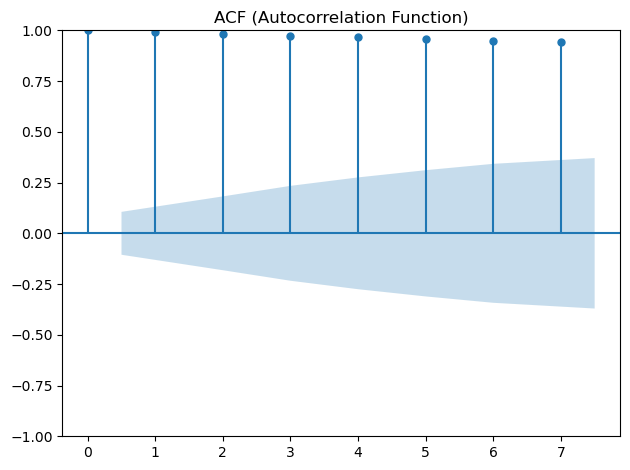

<Figure size 800x400 with 0 Axes>

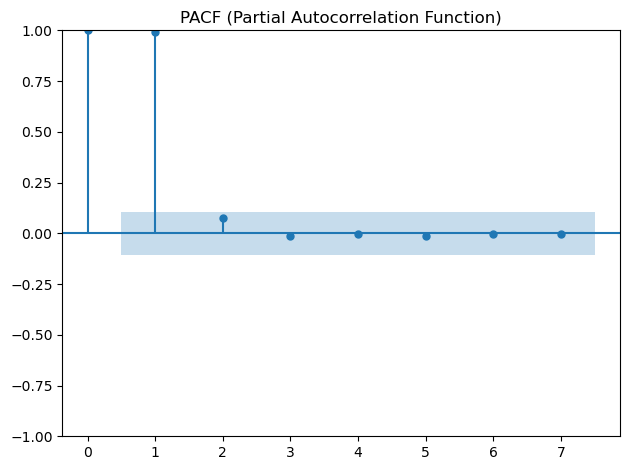

In [48]:
print("USD Time Series")
analyze_time_series(dfpivot["USD"], alpha=0.05, lags=7)

EUR Time Series
=== Zaman Serisi Özet Bilgileri ===
Gözlem sayısı: 344
Başlangıç tarihi: 2025-01-01
Bitiş tarihi    : 2025-12-10
Ortalama: 1.1183
Std sapma: 0.1085

=== 1) ADF Testi (Augmented Dickey-Fuller) ===
ADF İstatistiği: -1.3677
p-değeri       : 0.5976
Kullanılan lag : 0
Efektif gözlem : 343
Kritik değerler:
  1%: -3.4496
  5%: -2.8700
  10%: -2.5713
ℹ Sonuç (ADF): p ≥ 0.05 → H0 reddedilemez → Seri muhtemelen durağan DEĞİL (unit root var).

=== 2) KPSS Testi ===
KPSS İstatistiği: 2.8043
p-değeri         : 0.0100
Kritik değerler:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
❗ Sonuç (KPSS): p < 0.05 → H0 reddedilir → Seri muhtemelen durağan DEĞİL.

=== 3) ACF ve PACF Grafiklerini Çiziyorum ===


C:\Users\gulis\AppData\Local\Temp\ipykernel_9196\3094825854.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_clean, regression="c", nlags="auto")


<Figure size 800x400 with 0 Axes>

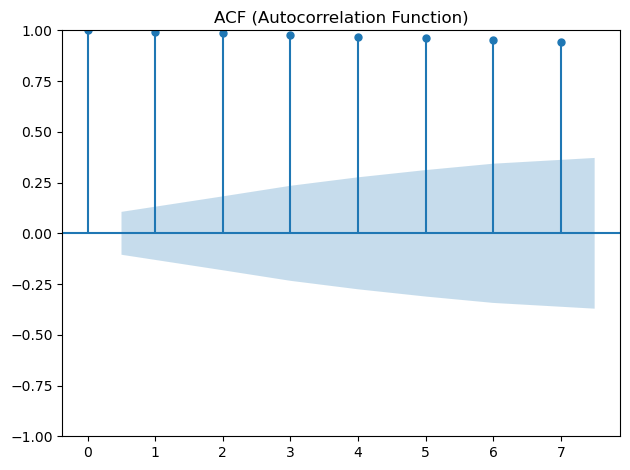

<Figure size 800x400 with 0 Axes>

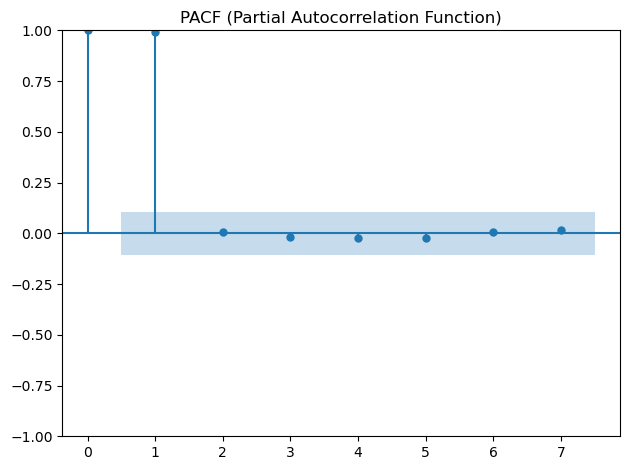

In [49]:
print("EUR Time Series")
analyze_time_series(dfpivot["EUR"], alpha=0.05, lags=7)

TRY Time Series
=== Zaman Serisi Özet Bilgileri ===
Gözlem sayısı: 344
Başlangıç tarihi: 2025-01-01
Bitiş tarihi    : 2025-12-10
Ortalama: 1.1141
Std sapma: 0.1942

=== 1) ADF Testi (Augmented Dickey-Fuller) ===
ADF İstatistiği: -2.0720
p-değeri       : 0.2559
Kullanılan lag : 17
Efektif gözlem : 326
Kritik değerler:
  1%: -3.4506
  5%: -2.8704
  10%: -2.5715
ℹ Sonuç (ADF): p ≥ 0.05 → H0 reddedilemez → Seri muhtemelen durağan DEĞİL (unit root var).

=== 2) KPSS Testi ===
KPSS İstatistiği: 1.3170
p-değeri         : 0.0100
Kritik değerler:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
❗ Sonuç (KPSS): p < 0.05 → H0 reddedilir → Seri muhtemelen durağan DEĞİL.

=== 3) ACF ve PACF Grafiklerini Çiziyorum ===


C:\Users\gulis\AppData\Local\Temp\ipykernel_9196\3094825854.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_clean, regression="c", nlags="auto")


<Figure size 800x400 with 0 Axes>

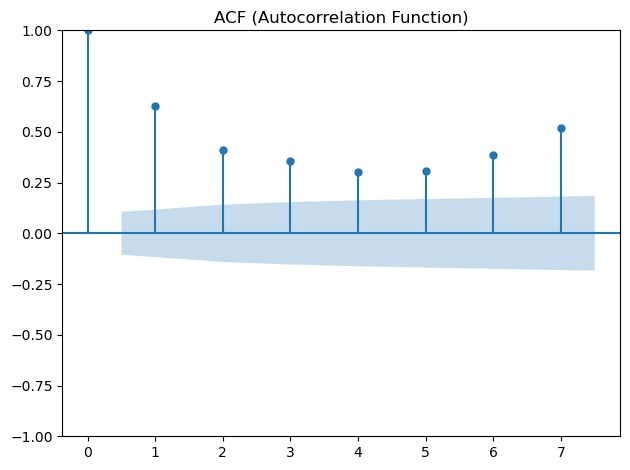

<Figure size 800x400 with 0 Axes>

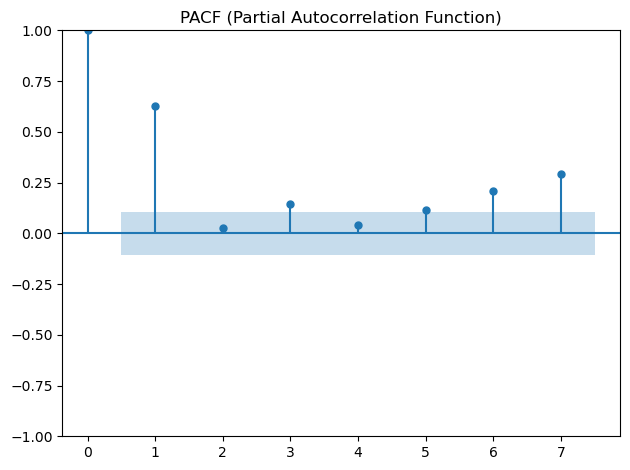

In [46]:
print("TRY Time Series")
analyze_time_series(dfpivot["TRY"], alpha=0.05, lags=7)

In [13]:
def optimalPortfolio(df: pd.DataFrame, C: float, gamma: float) -> Tuple[pd.Series, float, float]:
    """
    Interior mean–variance optimizer for procurement weights λ under:
        min_{λ}  C μ^T λ + γ C^2 λ^T Σ λ   s.t.  1^T λ = 1

    Parameters
    ----------
    df : pd.DataFrame
        Historical unit prices (not returns): rows = time, columns = instruments.
        NaNs are dropped row-wise before estimation.
    C : float
        Deterministic total energy requirement (> 0).
    gamma : float
        Risk aversion parameter on variance term (> 0).

    Returns
    -------
    np.ndarray
        The interior optimal weight vector λ* (length = number of columns in df).

    Notes
    -----
    - This returns the *interior* solution, which requires Σ ≻ 0 (SPD).
      If Σ is singular (e.g. a riskless/constant-price instrument or perfect collinearity),
      a ValueError is raised. In that case, remove/merge collinear sources or solve
      the full KKT system with inequality constraints as appropriate.
    - Uses a Cholesky factorization; no explicit matrix inverses are formed.
    """

    #Girdilerden kaynaklı anlamsız hataları verir
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame of historical unit prices.")
    if C <= 0:
        raise ValueError("C must be strictly positive.")
    if gamma <= 0:
        raise ValueError("gamma must be strictly positive.")


    # Nan varsa düşürür ve cov için en az iki satıra ihtiyaç var. 
    df_clean = df.dropna(how="any").astype(float)
    if df_clean.shape[0] < 2 or df_clean.shape[1] < 1:
        raise ValueError("Not enough data after dropping NaNs to estimate μ and Σ.")
    

    mu = df_clean.mean(axis=0).to_numpy()                 # E[p] 
    Sigma = df_clean.cov().to_numpy()                     # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T)                       # Symmetrize to dampen numerical asymmetry
    n = Sigma.shape[0]                                    # cov boyutu bulundu
    ones = np.ones(n)                                     # Birim vektör (cov boyutunda)

    # Cholesky-based solves to avoid explicit inversion ----- Bu blok, Σ’nın sağlıklı olduğunu garanti altına alıyor
    try:
        cF = cho_factor(Sigma, lower=True, check_finite=True)
    except LinAlgError as e:
        raise ValueError("Covariance matrix Σ is not SPD; interior solution undefined.") from e

    # Solve Σ x = 1 and Σ y = μ
    Sigma_inv_1 = cho_solve(cF, ones)                    #Σ^{−1} * 1
    Sigma_inv_mu = cho_solve(cF, mu)                     #Σ^{−1} * μ

    denom = float(ones @ Sigma_inv_1)                    # 1^T * Σ^{-1} * 1
    if denom <= 0 or not np.isfinite(denom):
        raise ValueError("Numerical issue: 1^T Σ^{-1} 1 must be positive and finite.")

    eta_num = 2.0 * gamma * (C**2) + C * float(ones @ Sigma_inv_mu)    # 2γC^{2} + C1^{⊤}Σ^{−1}μ
    eta = eta_num / denom                                              # [ 2γC^{2} + C1^{⊤}Σ^{−1}μ ] / [ 1^T * Σ^{-1} * 1] 

    # λ* = (1/(2 γ C^2)) [ Σ^{-1}(η 1 - C μ) ] = (1/(2 γ C^2)) (η Σ^{-1}1 - C Σ^{-1}μ)
    lam = (eta * Sigma_inv_1 - C * Sigma_inv_mu) / (2.0 * gamma * (C**2))
    # lam = (C * Sigma_inv_mu - eta * Sigma_inv_1) / (2.0 * gamma * (C**2))

    
    # Optional: enforce the affine constraint numerically (tiny adjustment)
    lam += (1.0 - lam.sum()) * (Sigma_inv_1 / denom)                   # 1^{⊤} * λ = 1 kısıtını mikro ayarla geri oturtur düzeltme amaçlıdır.

    w = pd.DataFrame(lam, index=df.columns )
    E = C * float(mu @ lam)
    V = (C**2) * float(lam @ Sigma @ lam)
    
    return w, E, V 

In [14]:
def optimalPortfoliononshort(
    df: pd.DataFrame,
    C: float,
    gamma: float,
    lower_bounds: Union[float, Sequence[float]] = 0.0,
    upper_bounds: Union[float, Sequence[float]] = 1.0,
    ridge: float = 1e-8,
) -> Tuple[pd.Series, float, float]:
    """
    Solve:  min_λ  C μ^T λ + γ C^2 λ^T Σ λ
            s.t.   1^T λ = 1,  lb ≤ λ ≤ ub
    df: price levels (rows=time, cols=sources). Returns (λ*, E[X], Var[X]).
    """
    if C <= 0 or gamma <= 0:
        raise ValueError("C and gamma must be > 0.")                              # risk katsayısı ve C >0 olmalı
    X = df.dropna(axis=1, how="all").dropna(axis=0, how="any").astype(float)      # Nan lar atılır
    if X.shape[0] < 2 or X.shape[1] < 1:
        raise ValueError("Not enough data.")                                      # Cov için boyutu minumum 2x2 olmalıdır

    mu = X.mean().to_numpy()                                                      # E[p]
    Sigma = X.cov(ddof=1).to_numpy()                                              # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T) + ridge * np.eye(len(mu))                     # Symmetrize to dampen numerical asymmetry
    n = len(mu)                                                                   # mu boyutu bulundu

    # expand bounds to vectors
    lb = np.full(n, lower_bounds if np.isscalar(lower_bounds) else np.asarray(lower_bounds, float))  #lower bound
    ub = np.full(n, upper_bounds if np.isscalar(upper_bounds) else np.asarray(upper_bounds, float))  #Upper bound
    if lb.sum() > 1 + 1e-12 or ub.sum() < 1 - 1e-12:
        raise ValueError("Infeasible bounds: need sum(lb) ≤ 1 ≤ sum(ub).")                           #sum(lb) ≤ 1 ≤ sum(ub) şartını manuel test ediyor

    # feasible start: begin at lb, spread remaining mass toward ub
    w0 = lb.copy()                                         # ilk olarak ağırlıklar minimuma eşitleniyor
    rem = 1.0 - w0.sum()                                   # Eşitlik koşulundan yola çıkarak 1'den çıkarılıyor
    if rem > 0:                                            # Ağırlıklar bulunur
        room = np.maximum(ub - w0, 0.0)
        total = room.sum()
        if total > 0: w0 += rem * (room / total)           # toplamın 1 e eşit olduğu sağlanır
    w0 = np.clip(w0, lb, ub)                               # ağırlıkları (w) sınırlar içinde burakır

    def fun(w):  return C * mu @ w + gamma * (C**2) * (w @ Sigma @ w)  #fonksiyon f(w)=Cμ⊤w+γC2w⊤Σw amaç fonk  scaler
    def jac(w):  return C * mu + 2.0 * gamma * (C**2) * (Sigma @ w)    #jacobien  ∇f(w)=Cμ+2γC2Σw   1. Türev   (n,)
    def hess(w): return 2.0 * gamma * (C**2) * Sigma                   #hessian   ∇2f(w)=2γC2Σ      2. Türev   (n,n)

    cons = [LinearConstraint(np.ones((1, n)), 1.0, 1.0)]                # w vektörü ve sınırlar toplamlar 1 e eşit
    bnds = Bounds(lb, ub)                                               # Sınırlar 
    opt  = minimize(fun, w0, method="trust-constr", jac=jac, hess=hess, # Optimizasyon tam olarak burda yapılır ve newton tabanlıdır.
                   bounds=bnds, constraints=cons,
                   options={"maxiter": 500, "gtol": 1e-10, "xtol": 1e-12, "verbose": 0})  
    #gtol=1e-10	Gradyan normu bu değerden küçükse dur.
    #xtol=1e-12	w vektöründeki değişim bu değerden küçükse dur.
    #maxiter=500	Maksimum iterasyon sayısı.
    #verbose=0	Çıktı susturulmuş. 2 yapsan her adımı loglar.
    
    
    if not opt.success:
        raise RuntimeError(f"Optimization failed: {opt.message}")  # algoritmanın neden durduğunu açıklayan yazı "opt.***" gibi türev bilgi verilebilir.

    w = pd.Series(opt.x, index=X.columns, name="λ*")
    E = C * float(mu @ opt.x)
    V = (C**2) * float(opt.x.T @ Sigma @ opt.x)
    return w, E, V

C ve gamma'nın sıfırdan büyük olması şarttır. İki fonksiyonda da (sort ve nonshort) bu kısıtlar mevcuttur. 

- C > 0 olmak zorundadır. Talebin sıfır ve daha küçük olması anlamsızdır.
- gamma > 0 olmak zorundadır.
  * gamma riskten kaçınma katsayısıdır.
  * gamma = 0 olursa E[R] minimize olur.
  * gamma < 0 olursa risk sever bir durum olmakla birlikte varyansı maksimize etmeye iter ve problem ekonomik olarak anlamsızlaşabilir. 
  

In [15]:
prices = dfpivot[["USD","EUR","TRY"]].dropna()
prices.reset_index(drop=True, inplace=True)
#prices = df2.dropna()
C=10000
gamma= 1.00  #risk katsayısı
n = prices.shape[1]                                    # cov boyutu bulundu
upper_bounds = np.ones(n)   

w, E, V = optimalPortfoliononshort(prices, C=C, gamma=gamma,  upper_bounds=upper_bounds)
print("non sort position")
print(w.round(6))
print(f"Expected cost: {E:,.2f}  |  Variance: {V**0.5:,.2f}")

print("with sort position")
w1, E1, V1 =  optimalPortfolio(prices,C,gamma)
print(w1.round(6))
print(f"Expected cost: {E1:,.2f}  |  Variance: {V1**0.5:,.2f}")



non sort position
USD    1.0
EUR    0.0
TRY    0.0
Name: λ*, dtype: float64
Expected cost: 11,136.23  |  Variance: 639.07
with sort position
            0
USD  2.245945
EUR -1.236266
TRY -0.009679
Expected cost: 11,078.51  |  Variance: 263.18


Monte Carlo Simulation 

In [16]:
mu    = prices.mean().to_numpy()                                                      # E[p]
Sigma = prices.cov(ddof=1).to_numpy()      
C = C
λ1 = w1.values #non -short
λ2 = w.values  #with short 

# 10.000 senaryo simülasyonu
n_sim = 10_000
p = np.random.multivariate_normal(mu, Sigma, n_sim)   # ortalama maliyet üretildi. Rastgele ama mantıklı. 


# Toplam maliyet
X1 = C * p @ λ1 #non -short
X2 = C * p @ λ2 #with short 

# İstatistikler

mean_cost_withshort  = X1.mean()
std_dev_withshort    = X1.var() **0.5
mean_cost_nonshort   = X2.mean()
std_dev_nonshort     = X2.var() **0.5

print(f"Monte C Simulation Non Short Beklenen Maliyet: {mean_cost_nonshort:.2f}, Varyans: {std_dev_nonshort:.2f}")
print(f"Monte C Simulation WithShort Beklenen Maliyet: {mean_cost_withshort:.2f}, Varyans: {std_dev_withshort:.2f}")
print(f"Manuel Calculation Non Short Beklenen Maliyet: {E:,.2f}, Varyans: {V**0.5:.2f}")
print(f"Manuel Calculation WithShort Beklenen Maliyet: {E1:.2f}, Varyans: {V1**0.5:.2f}")

Monte C Simulation Non Short Beklenen Maliyet: 11132.58, Varyans: 641.20
Monte C Simulation WithShort Beklenen Maliyet: 11076.43, Varyans: 262.52
Manuel Calculation Non Short Beklenen Maliyet: 11,136.23, Varyans: 639.07
Manuel Calculation WithShort Beklenen Maliyet: 11078.51, Varyans: 263.18
